In [2]:
from Preprocessing_M_test import DataExtractor, DataPreprocessing

directory = r"C:\Users\maxda\Studium\Semester6\IoT\Gebäude_Daten"
new_directory = r"C:\Users\maxda\Studium\Semester6\IoT\Gebäude_Daten"
de = DataExtractor(first_directory=directory, new_directory=new_directory)

df = de.create_df()

Read data successfully.
Data contains 979166 data points and 18 columns.


In [3]:
dp = DataPreprocessing(roll=True)

df_preprocessed = dp.preprocess_df(df, rolling_window = "3d", sample_time = "1d")

Number of outliers detected: -73438
Number of normal samples detected: 905728


In [4]:
df_preprocessed

,date_time,tmp,hum,CO2,VOC,vis,IR,BLE,tavg,tmin,...,wdir_diff,wspd_diff,wpgt_diff,pres_diff,year,dayofweek,hour,season,color,VOC_CO2_ratio
0,2022-06-01,25.259375,31.653750,573.500000,450.062500,187.375000,86.687500,22.437500,15.40,11.0,...,0.0,0.0,0.0,0.00,1,2,0,summer,green,0.7848
1,2022-06-02,25.167642,33.097784,538.500000,450.531250,124.801136,49.480114,11.900568,15.75,11.1,...,-15.5,0.1,0.9,0.05,1,3,0,summer,green,0.8366
2,2022-06-03,25.167642,33.097784,538.500000,450.531250,124.801136,49.480114,11.900568,15.75,11.1,...,0.0,0.0,0.0,0.00,1,4,0,summer,green,0.8366
3,2022-06-04,25.075909,34.541818,503.500000,451.000000,62.227273,12.272727,1.363636,16.10,11.2,...,-15.5,0.1,0.9,0.05,1,5,0,summer,green,0.8957
4,2022-06-20,26.680611,44.075224,515.179104,98.046133,5.135685,2.016282,0.000000,16.10,11.2,...,0.0,0.0,0.0,0.00,1,0,0,summer,green,0.1903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6367,2023-09-26,23.224375,48.668706,518.128201,1087.445455,122.367831,45.060275,1.919880,16.10,11.2,...,0.0,0.0,0.0,0.00,2,1,0,fall,green,2.0988
6368,2023-09-26,22.114866,54.305095,563.831172,955.904609,70.605667,19.029507,6.583299,16.10,11.2,...,0.0,0.0,0.0,0.00,2,1,0,fall,green,1.6954
6369,2023-09-26,22.467122,56.152477,542.884728,1247.546420,20.677347,6.422801,5.123845,16.10,11.2,...,0.0,0.0,0.0,0.00,2,1,0,fall,green,2.2980
6370,2023-09-26,21.433265,52.649841,674.438142,1308.915237,122.573153,41.795220,3.298549,16.10,11.2,...,0.0,0.0,0.0,0.00,2,1,0,fall,green,1.9407


In [33]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'tavg',
       'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'room_number',
       'time_diff_sec', 'hum_diff', 'CO2_diff', 'VOC_diff', 'vis_diff',
       'IR_diff', 'BLE_diff', 'tavg_diff', 'tmin_diff', 'tmax_diff',
       'prcp_diff', 'wdir_diff', 'wspd_diff', 'wpgt_diff', 'pres_diff', 'year',
       'dayofweek', 'hour', 'season', 'color', 'VOC_CO2_ratio'],
      dtype='object')

In [34]:
from Feature_Engineering_test import *

fe = FeatureEngineering(df_preprocessed.drop(columns = ["VOC_CO2_ratio"]), 
                        label = "CO2", 
                        categorical_features = ["season", "room_number", "color"],
                        automated_feature_engineering = False)

X_train, X_test,y_train, y_test = fe.feature_engineering(skip_scale = True)

In [35]:
df_train = fe.X_train
df_train["CO2"] = fe.y_train

In [36]:
df_train.columns

Index(['year', 'dayofweek', 'hour', 'tmp', 'hum', 'VOC', 'vis', 'IR', 'BLE',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'hum_diff', 'CO2_diff', 'VOC_diff', 'vis_diff', 'IR_diff', 'BLE_diff',
       'tavg_diff', 'tmin_diff', 'tmax_diff', 'prcp_diff', 'wdir_diff',
       'wspd_diff', 'wpgt_diff', 'pres_diff', 'season_fall', 'season_spring',
       'season_summer', 'season_winter', 'room_number_m001',
       'room_number_m002', 'room_number_m003', 'room_number_m004',
       'room_number_m101', 'room_number_m102', 'room_number_m103',
       'room_number_m104', 'room_number_m105', 'room_number_m113',
       'room_number_m201', 'room_number_m202', 'room_number_m206',
       'room_number_m207', 'room_number_m209', 'room_number_m216',
       'room_number_m301', 'room_number_m302', 'room_number_m303',
       'room_number_m304', 'room_number_m306', 'room_number_m310',
       'room_number_m700', 'room_number_mu04', 'room_number_mu06',
       'room_number_mu10', 

In [37]:
df_test = fe.X_test
df_test["CO2"] = fe.y_test

In [40]:
def transform_data_for_forecasting(data, label_name, n_in, n_out, dropna = True):

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data[[f"{label_name}"]].shift(-i))
        if i == 0:
            names += [f"{label_name}(t)"]
        else:
            names += [f"{label_name}(t+{i})"]
        # put it all together
        data_reframed = pd.concat(cols, axis=1)
        data_reframed.columns = names
        # drop rows with NaN values
        if dropna:
            data_reframed.dropna(inplace=True)

    return data_reframed

In [41]:
train_reframed = transform_data_for_forecasting(df_train, "CO2", 1, 1)
test_reframed = transform_data_for_forecasting(df_test, "CO2", 1, 1)

train_reframed

,year(t-1),dayofweek(t-1),hour(t-1),tmp(t-1),hum(t-1),VOC(t-1),vis(t-1),IR(t-1),BLE(t-1),tavg(t-1),...,room_number_mu04(t-1),room_number_mu06(t-1),room_number_mu10(t-1),room_number_mu11(t-1),color_green(t-1),color_red(t-1),color_red_blinking(t-1),color_yellow(t-1),CO2(t-1),CO2(t)
date_time,,,,,,,,,,,,,,,,,,,,,
2022-06-03,1.0,3.0,0.0,1.114874,-1.101881,-1.473167,-0.388884,-0.173530,0.805733,-50.472765,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,538.500000,538.500000
2022-06-04,1.0,4.0,0.0,1.114874,-1.101881,-1.473167,-0.388884,-0.173530,0.805733,-50.472765,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,538.500000,503.500000
2022-06-20,1.0,5.0,0.0,1.079663,-0.905436,-1.471903,-0.672908,-0.756853,-0.566383,0.019813,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,503.500000,515.179104
2022-06-21,1.0,0.0,0.0,1.695601,0.391480,-2.423954,-0.932049,-0.917650,-0.743955,0.019813,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,515.179104,507.515814
2022-06-22,1.0,1.0,0.0,1.533461,0.143082,-2.407737,-0.934613,-0.920114,-0.743955,0.019813,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,507.515814,508.658103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29,2.0,3.0,0.0,2.671227,-0.967180,1.637236,0.553276,0.732259,-0.237451,0.019813,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,435.476523,449.072289
2023-06-29,2.0,3.0,0.0,1.849408,-1.197282,1.041311,2.257722,4.294241,0.958315,0.019813,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,449.072289,455.099311
2023-06-29,2.0,3.0,0.0,2.188369,-0.830713,1.422207,1.161243,2.098378,0.344534,0.019813,...,-0.207295,-0.208834,-0.014008,-0.195155,0.304695,-0.052481,-0.019813,-0.298501,455.099311,446.152414


In [42]:
from sklearn.preprocessing import StandardScaler

def transform_to_numpy_array(train_data, test_data, n_out):
    # split into train and test sets
    values_train = train_data.values
    values_test = test_data.values
    # split into input and outputs
    train = values_train[:, :]
    test = values_test[:, :]

    train_X, train_y = train[:, :-n_out], train[:, -n_out:]
    test_X, test_y = test[:, :-n_out], test[:, -n_out:]

    sc = StandardScaler()

    train_X = sc.fit_transform(train_X)
    test_X = sc.transform(test_X)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    train_X = np.asarray(train_X).astype('float32')
    train_y = np.asarray(train_y).astype('float32')

    test_X = np.asarray(test_X).astype('float32')
    test_y = np.asarray(test_y).astype('float32')

    return train_X, train_y, test_X, test_y, sc

train_X, train_y, test_X, test_y, scaler = transform_to_numpy_array(train_reframed, test_reframed, 1)

(5096, 1, 67) (5096, 1) (1273, 1, 67) (1273, 1)


In [43]:
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
# from keras.optimizers import Adam, SGD
# from matplotlib import pyplot

# class MyLSTMModel:
#     def __init__(self, lstm_units=int(fe.X_train.shape[1]*2),input_shape=(None, fe.X_train.shape[1])):
#         self.model = Sequential()
#         self.model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences = True))
#         self.model.add(Dropout(0.4))
#         self.model.add(LSTM(units=lstm_units*2, return_sequences = True))
#         self.model.add(Dropout(0.3))
#         self.model.add(Dropout(0.3))
#         self.model.add(Bidirectional(LSTM(units=lstm_units)))
#         self.model.add(Dropout(0.3))
#         self.model.add(Dense(50, activation = "relu"))
#         self.model.add(Dense(30, activation = "relu"))
#         self.model.add(Dense(15, activation = "relu"))

#         self.model.add(Dense(1)) 

#         self.model.compile(optimizer="adam", loss='mse')
    
#     def summary(self):
#         self.model.summary()

# # Instantiate the model
# my_model = MyLSTMModel()

# history = my_model.model.fit(train_X, train_y, epochs=10, batch_size=12, verbose=2, shuffle=False)

# pyplot.plot(history.history['loss'], label='train')
# # pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

Epoch 1/25
637/637 - 5s - loss: 298.3397 - 5s/epoch - 8ms/step
Epoch 2/25
637/637 - 2s - loss: 137.3409 - 2s/epoch - 3ms/step
Epoch 3/25
637/637 - 2s - loss: 123.7768 - 2s/epoch - 3ms/step
Epoch 4/25
637/637 - 2s - loss: 117.6394 - 2s/epoch - 3ms/step
Epoch 5/25
637/637 - 2s - loss: 112.3904 - 2s/epoch - 3ms/step
Epoch 6/25
637/637 - 2s - loss: 109.0164 - 2s/epoch - 3ms/step
Epoch 7/25
637/637 - 2s - loss: 106.2698 - 2s/epoch - 3ms/step
Epoch 8/25
637/637 - 2s - loss: 104.7631 - 2s/epoch - 3ms/step
Epoch 9/25
637/637 - 2s - loss: 102.1195 - 2s/epoch - 3ms/step
Epoch 10/25
637/637 - 2s - loss: 102.8395 - 2s/epoch - 3ms/step
Epoch 11/25
637/637 - 2s - loss: 102.3259 - 2s/epoch - 3ms/step
Epoch 12/25
637/637 - 2s - loss: 101.1003 - 2s/epoch - 3ms/step
Epoch 13/25
637/637 - 2s - loss: 98.4044 - 2s/epoch - 3ms/step
Epoch 14/25
637/637 - 2s - loss: 99.8894 - 2s/epoch - 3ms/step
Epoch 15/25
637/637 - 2s - loss: 98.5680 - 2s/epoch - 3ms/step
Epoch 16/25
637/637 - 2s - loss: 97.6905 - 2s/epoch 

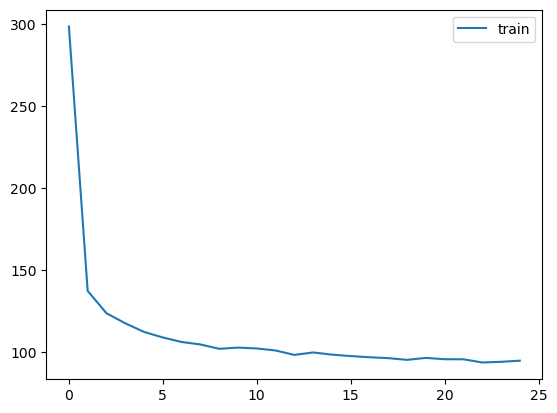

In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=8, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Annahme: scaler ist der gleiche Skaler, der auch zum Skalieren der Trainingsdaten verwendet wurde

# Hier ist der Teil, der die Vorhersagen und die tatsächlichen Werte rücktransformiert:
# make a prediction
yhat = model.predict(test_X)
# test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat, test_X_new[:, 1:]), axis=1)
# # inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, 0]

# # invert scaling for actual
# test_y_new = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y_new, test_X_new[:, 1:]), axis=1)
# # inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test[1:], yhat))
print('Test RMSE: %.3f' % rmse)

prediction_df = y_test[1:].to_frame()
prediction_df["pred"] = yhat

40/40 [==============================] - 1s 2ms/step
Test RMSE: 78.120


In [74]:
prediction_df["baseline"] = 580

In [75]:

rmse = np.sqrt(mean_squared_error(y_test[1:], prediction_df.baseline))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 128.358


In [68]:
prediction_df

,CO2,pred,baseline
date_time,,,
2023-06-29,466.000000,493.921967,472
2023-06-29,431.152687,463.031219,472
2023-06-30,424.408974,497.197723,472
2023-06-30,432.748992,465.262756,472
2023-06-30,500.668526,482.132629,472
...,...,...,...
2023-09-26,489.538947,547.923828,472
2023-09-26,632.766618,514.307922,472
2023-09-26,577.051717,546.269897,472


In [26]:
import plotly.express as px

px.line(prediction_df, x=prediction_df.index, y=["CO2", "pred"])

In [52]:
pred = model.predict(test_X)

pred

40/40 [==============================] - 0s 4ms/step


array([[493.92197],
       [463.03122],
       [497.19772],
       ...,
       [546.2699 ],
       [647.4093 ],
       [518.34216]], dtype=float32)

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import plotly.express as px
import seaborn as sns


class Evaluator:

    def __init__(self):
        pass

    def evaluate(self, y_pred, y_true):
        print("MSE: ", self.calculate_mse(y_pred = y_pred, y_true = y_true))
        print("RMSE: ", self.calculate_rmse(y_pred = y_pred, y_true = y_true))
        print("MAPE: ", self.calculate_mape(y_pred = y_pred, y_true = y_true))
        print("R2: ", self.calculate_r2(y_pred = y_pred, y_true = y_true))
        print("\n")


    def calculate_mse(self, y_true, y_pred):
        return round(mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_rmse(self, y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
        #return round(root_mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_mape(self, y_true, y_pred):
        return round(mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_r2(self, y_true, y_pred):
        return round(r2_score(y_true = y_true, y_pred = y_pred), 2)


ev = Evaluator()

for col in range(0, test_y.shape[1]):
    print(f"t +", col)
    ev.evaluate(y_true = test_y[:, col], y_pred = pred[:, col])

    pred_df = pd.DataFrame(pred[:, col], columns = [f"pred_CO2(t + {col})"])
    pred_df[f"CO2(t + {col})"] = test_y[:, col]

    px.line(y = [test_y[:, col], pred[:, col]], title = f"Prediction for CO2(t + {col})      blue = y_true, red = y_pred").show()

t + 0
MSE:  6102.79
RMSE:  78.12033
MAPE:  0.1
R2:  -0.25


